In [ ]:
# ====================================
# Notebook 1: Data Preprocessing
# Description:
# This notebook preprocesses the raw transactional data stored in two zipped JSON Line files.
# It removes duplicates, filters infrequent users and items, creates mappings,
# and saves encoded data for use in downstream recommender systems.
# ====================================

In [ ]:
import os

# === Clone GitHub repository ===
repo_dir = "My-BS-Thesis"

if os.path.exists(repo_dir):
    print(f"{repo_dir} already exists. Removing it...\n")
    !rm -r {repo_dir}

!git clone https://github.com/Goshmar/My-BS-Thesis

Cloning into 'My-BS-Thesis'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 50 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 50.94 MiB | 23.47 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
# === Install dependencies from requirements.txt ===
!pip install -r My-BS-Thesis/requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.7/557.7 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 768.5/768.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# === Unzip the data files ===
data_dir = os.path.join(repo_dir, 'data/raw')
interim_data_dir = os.path.join(repo_dir, 'data/interim')

zip1_path = os.path.join(data_dir, 'raw_data_part1.zip')
zip2_path = os.path.join(data_dir, 'raw_data_part2.zip')

with zipfile.ZipFile(zip1_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

with zipfile.ZipFile(zip2_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [ ]:
# === Load and merge JSON parts ===
def load_json_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

part1_path = os.path.join(data_dir, 'raw_data_part1.json')
part2_path = os.path.join(data_dir, 'raw_data_part2.json')

data_part1 = load_json_lines(part1_path)
data_part2 = load_json_lines(part2_path)

orders_data = data_part1 + data_part2

In [ ]:
# === Raw order example ===
orders_data[0]

{'заказ': '1',
 'дата': '20.01.2023 8:16:56',
 'подразделение': '1',
 'СуммаЗаказа': '26\xa0605',
 'товары': [{'кол.': '35',
   'цена': '597',
   'Сумма': '20\xa0895',
   'название': '1',
   'группа': '1'},
  {'кол.': '3',
   'цена': '656',
   'Сумма': '1\xa0968',
   'название': '2',
   'группа': '2'},
  {'кол.': '1',
   'цена': '1\xa0812',
   'Сумма': '1\xa0812',
   'название': '3',
   'группа': '3'},
  {'кол.': '5', 'цена': '70', 'Сумма': '350', 'название': '4', 'группа': '4'},
  {'кол.': '10',
   'цена': '140',
   'Сумма': '1\xa0400',
   'название': '5',
   'группа': '5'},
  {'кол.': '1',
   'цена': '180',
   'Сумма': '180',
   'название': '6',
   'группа': '6'}]}

In [ ]:
# === Helper function for cleaning numeric fields ===
def clean_number(value, is_int=False):
    if value is None or value == "":
        return 0 if is_int else 0.0
    value = str(value).replace("\u00a0", "").replace(",", ".").strip()
    try:
        num = float(value)
        return int(round(num)) if is_int else num
    except ValueError:
        return 0 if is_int else 0.0

# === Transform JSON into DataFrame ===
data = []
for order in tqdm(orders_data, desc="Processing orders"):
    order_id = clean_number(order["заказ"], is_int=True)
    date = pd.to_datetime(order["дата"], format="%d.%m.%Y %H:%M:%S")
    subunit = order["подразделение"]
    amount = clean_number(order["СуммаЗаказа"])

    products = {}
    for item in order["товары"]:
        product_name = item["название"]
        group_path = item["группа"]
        products[product_name] = [
            clean_number(item["кол."], is_int=True),
            clean_number(item["цена"]),
            clean_number(item["Сумма"]),
            group_path
        ]
    data.append([order_id, date, subunit, amount, products])

df = pd.DataFrame(data, columns=["id", "date", "subunit", "amount", "products"])

Processing orders: 100%|██████████| 665733/665733 [01:56<00:00, 5711.96it/s]


In [ ]:
# Transformed order example
df.sample(5)

,id,date,subunit,amount,products
558243,558244,2024-09-12 10:42:54,3,711.0,"{'18ea': [3, 237.0, 711.0, '18ea']}"
11704,11705,2023-02-10 09:12:03,9,535.0,"{'9aa': [1, 400.0, 400.0, '9aa'], '46b': [1, 1..."
254991,254992,2023-12-10 15:50:09,1,445.0,"{'11c': [1, 445.0, 445.0, '11c']}"
43883,43884,2023-03-24 16:17:04,6,1000.0,"{'a53': [2, 525.0, 1000.0, 'a53']}"
422435,422436,2024-11-06 10:20:05,9,215.0,"{'1117': [1, 185.0, 185.0, '1117'], '343': [2,..."



DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665733 entries, 0 to 665732
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   id       665733 non-null  int64         
 1   date     665733 non-null  datetime64[ns]
 2   subunit  665733 non-null  object        
 3   amount   665733 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 20.3+ MB
None
                  id                           date        amount
count  665733.000000                         665733  6.657330e+05
mean   332867.000000  2024-02-19 17:41:34.525035520  1.154003e+04
min         1.000000            2023-01-01 00:00:00  1.000000e-02
25%    166434.000000            2023-08-21 13:15:37  3.060000e+02
50%    332867.000000            2024-03-05 08:59:30  1.000000e+03
75%    499300.000000            2024-08-25 11:53:37  3.618000e+03
max    665733.000000            2025-02-19 1

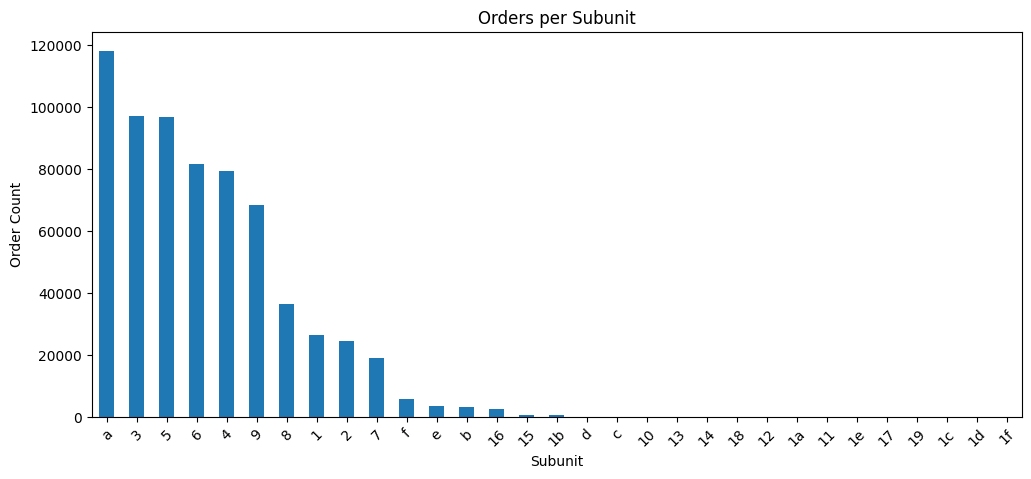

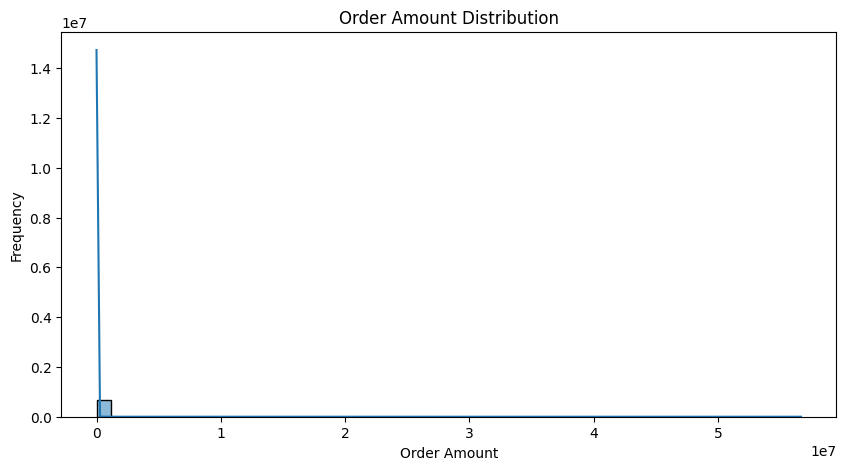

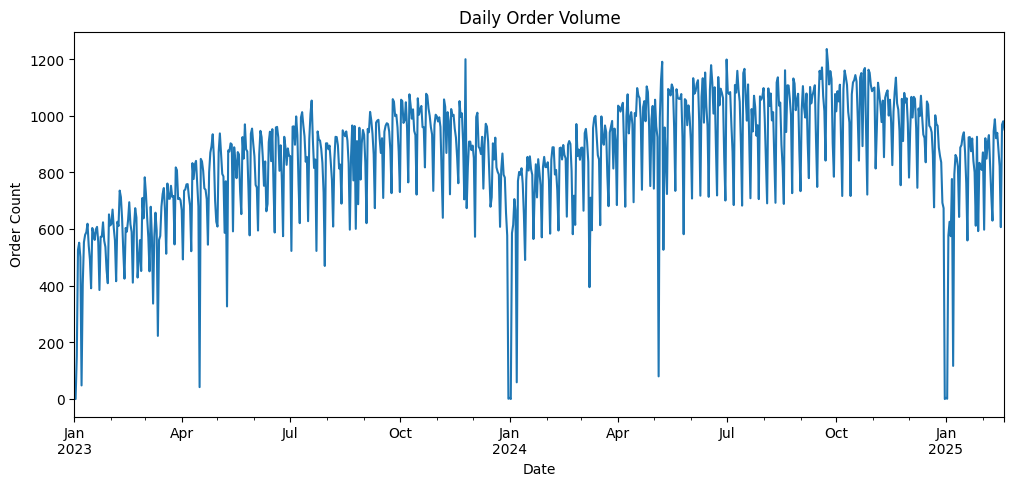

In [ ]:
# === Basic statistics ===
print("\nDataFrame Overview:")
print(df.drop(columns=["products"]).info())
print(df.drop(columns=["products"]).describe())
print("Duplicated records:", df.drop(columns=["products"]).duplicated().sum())
print("Missing values:")
print(df.isnull().sum())

# === Subunit distribution ===
plt.figure(figsize=(12, 5))
df["subunit"].value_counts().plot(kind="bar")
plt.title("Orders per Subunit")
plt.xlabel("Subunit")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.show()

# === Order amount distribution ===
plt.figure(figsize=(10, 5))
sns.histplot(df["amount"], bins=50, kde=True)
plt.title("Order Amount Distribution")
plt.xlabel("Order Amount")
plt.ylabel("Frequency")
plt.show()

# === Daily order trend ===
df["date"] = pd.to_datetime(df["date"])
df.set_index("date")["id"].resample("D").count().plot(figsize=(12, 5))
plt.title("Daily Order Volume")
plt.xlabel("Date")
plt.ylabel("Order Count")
plt.show()

In [ ]:
# === Filter subunits (non-relevant domain information) ===
excluded_subunits = ["3", "7", "13", "15", "d", "c", "1b"]
df = df[~df["subunit"].isin(excluded_subunits)]

# Keep only subunits with ≥ 100 orders
valid_subunits = df["subunit"].value_counts()
valid_subunits = valid_subunits[valid_subunits >= 100].index
df = df[df["subunit"].isin(valid_subunits)]

# Filter by 5th–95th percentile of order amounts
lower_bound = df["amount"].quantile(0.05)
upper_bound = df["amount"].quantile(0.95)
df = df[(df["amount"] >= lower_bound) & (df["amount"] <= upper_bound)]

print(f"Remaining orders after filtering: {len(df)}")

Remaining orders after filtering: 492999


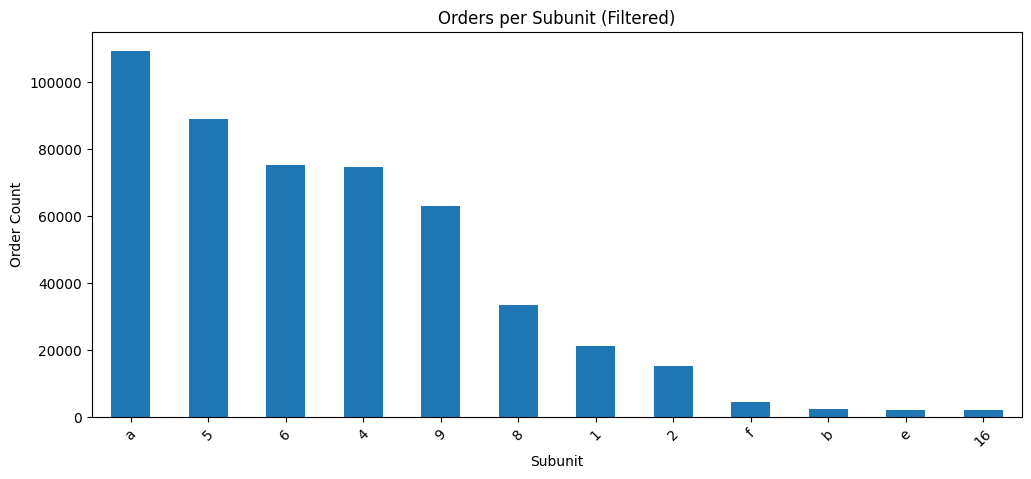

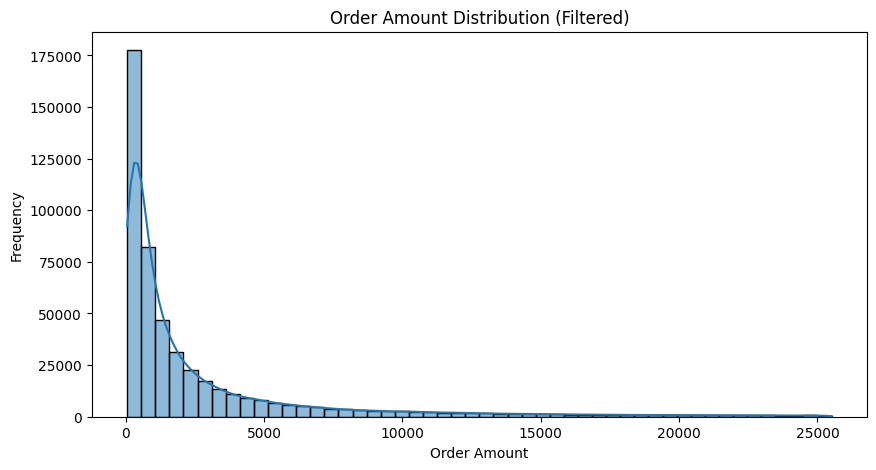

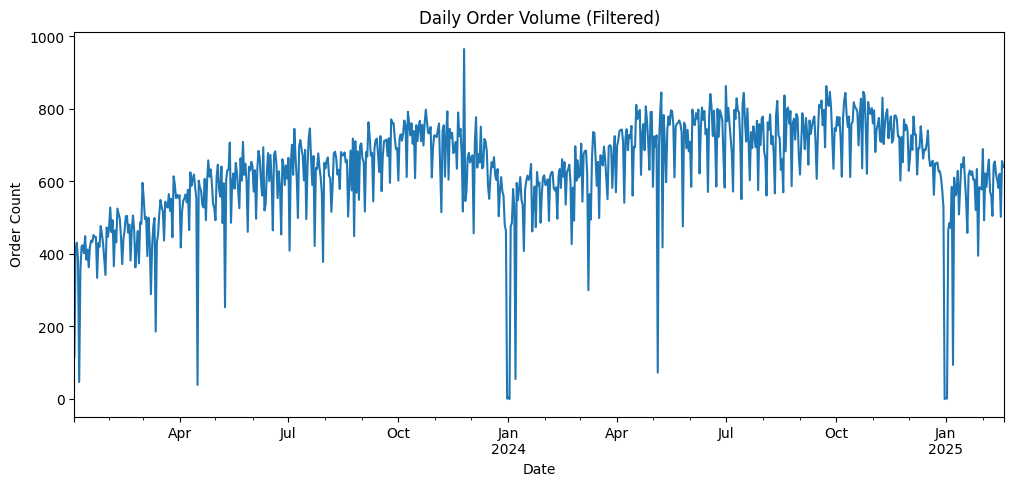

In [ ]:
# === Visualizations after filtering ===
plt.figure(figsize=(12, 5))
df["subunit"].value_counts().plot(kind="bar")
plt.title("Orders per Subunit (Filtered)")
plt.xlabel("Subunit")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["amount"], bins=50, kde=True)
plt.title("Order Amount Distribution (Filtered)")
plt.xlabel("Order Amount")
plt.ylabel("Frequency")
plt.show()

df.set_index("date")["id"].resample("D").count().plot(figsize=(12, 5))
plt.title("Daily Order Volume (Filtered)")
plt.xlabel("Date")
plt.ylabel("Order Count")
plt.show()

In [ ]:
# === Save filtered DataFrame ===
filtered_path = os.path.join(interim_data_dir, "filtered_orders.csv")
df.to_csv(filtered_path, index=False)
print(f"Filtered DataFrame saved to '{filtered_path}'")

Filtered DataFrame saved to 'My-BS-Thesis/data/interim/filtered_orders.csv'


In [ ]:
# === Zip the filtered CSV file ===
zip_path = os.path.join(interim_data_dir, "filtered_orders.zip")

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(filtered_path, arcname=os.path.basename(filtered_path))

# Remove the original CSV/JSON files to save space
os.remove(filtered_path)
os.remove(part1_path)
os.remove(part2_path)

print(f"Filtered orders compressed and saved as '{zip_path}'")

Filtered orders compressed and saved as 'My-BS-Thesis/data/interim/filtered_orders.zip'
